Sveučilište u Zagrebu
Fakultet elektrotehnike i računarstva
  
## Strojno učenje 1 2021/2022
http://www.fer.unizg.hr/predmet/struce1

------------------------------

### Logistička regresija

*Verzija: 1.0 
Zadnji put ažurirano: 1. 10. 2021.*

(c) 2015-2021 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **7. studenog 2021. u 23:59h**

------------------------------

### Upute

Ova laboratorijska vježba sastoji se od četiri zadatka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [18]:
import math

import numpy as np
import sklearn
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['degrees', 'exp', 'norm', 'f', 'log', 'poly', 'e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [19]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None :
        # Create a mesh to plot in
        r = 0.04  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

### 1. Logistička regresija

Ovaj zadatak bavi se probabilističkim diskriminativnim modelom, **logističkom regresijom**, koja je, unatoč nazivu, klasifikacijski model.

Logistička regresija tipičan je predstavnik tzv. **poopćenih linearnih modela** koji su oblika: $h(\mathbf{x})=f(\mathbf{w}^\intercal\tilde{\mathbf{x}})$. Logistička funkcija za funkciju $f$ koristi tzv. **logističku** (sigmoidalnu) funkciju $\sigma (x) = \frac{1}{1 + \textit{exp}(-x)}$.

### (a)  

Definirajte logističku (sigmoidalnu) funkciju $\mathrm{sigm}(x)=\frac{1}{1+\exp(-\alpha x)}$ i prikažite je za $\alpha\in\{1,2,4\}$.

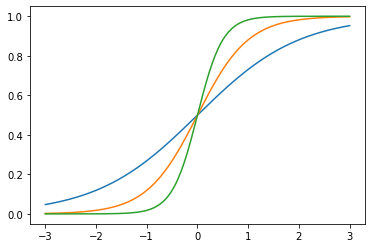

In [20]:
from math import exp
from numpy import linspace
from sklearn.preprocessing import PolynomialFeatures

def sigmoid(x):
    return 1 / (1 + exp(-x))

alphas = [1, 2, 4]

xRange = linspace(-3,3, 200)
yList = [[], [], []]

for a in range(len(alphas)):
    for x in xRange:
        yList[a].append(sigmoid(x*alphas[a]))

for i in range(len(yList)):
    plt.plot(xRange, yList[i])

**Q**: Zašto je sigmoidalna funkcija prikladan izbor za aktivacijsku funkciju poopćenoga linearnog modela? 
</br>

**Q**: Kakav utjecaj ima faktor $\alpha$ na oblik sigmoide? Što to znači za model logističke regresije (tj. kako izlaz modela ovisi o normi vektora težina $\mathbf{w}$)?

### (b) 

Implementirajte funkciju 

> `lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False)` 

za treniranje modela logističke regresije gradijentnim spustom (*batch* izvedba). Funkcija uzima označeni skup primjera za učenje (matrica primjera `X` i vektor oznaka `y`) te vraća $(n+1)$-dimenzijski vektor težina tipa `ndarray`. Ako je `trace=True`, funkcija dodatno vraća listu (ili matricu) vektora težina $\mathbf{w}^0,\mathbf{w}^1,\dots,\mathbf{w}^k$ generiranih kroz sve iteracije optimizacije, od 0 do $k$. Optimizaciju treba provoditi dok se ne dosegne `max_iter` iteracija, ili kada razlika u pogrešci unakrsne entropije između dviju iteracija padne ispod vrijednosti `epsilon`. Parametar `alpha` predstavlja faktor L2-regularizacije.

Preporučamo definiranje pomoćne funkcije `lr_h(x,w)` koja daje predikciju za primjer `x` uz zadane težine `w`. Također, preporučamo i funkciju `cross_entropy_error(X,y,w)` koja izračunava pogrešku unakrsne entropije modela na označenom skupu `(X,y)` uz te iste težine.

**NB:** Obratite pozornost na to da je način kako su definirane oznake ($\{+1,-1\}$ ili $\{1,0\}$) kompatibilan s izračunom funkcije gubitka u optimizacijskome algoritmu.

In [21]:
from sklearn.metrics import log_loss
from math import log
from numpy import linalg, zeros
def lr_h(x, w):
    phi = PolynomialFeatures(1).fit_transform(x.reshape(1, -1))
    predict = sigmoid(phi @ w)
    return predict

def cross_entropy_error(X,y,w):
    phi = PolynomialFeatures(1).fit_transform(X).tolist()
    s = []
    for i in range(len(y)):
        s.append(sigmoid(np.dot(phi[i], w)))
        #print(s[i])
    out = log_loss(y, s)
    return out

def lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False):
    w_til = zeros(len(X[0])+1)
    N = len(X)
    eFirst = pow(epsilon, -1)
    wHistory = []
    for iteration in range(max_iter):
        deltaWz = 0
        deltaW = zeros(len(X[0]))
        e = 0
        for i in range(N):
            h = lr_h(X[i], w_til)
            deltaWz += h - y[i]
            deltaW += (h-y[i])*X[i]
            e += -y[i] * log(h) - (1 - y[i]) * log(1 - h)
        if abs(e - eFirst) < epsilon:
            #print("Less then epsilon, iter", iteration)
            break

        eFirst = e
        w_til[0] -= eta * deltaWz
        w_til[1:] = w_til[1:] * (1-eta*alpha) - eta*deltaW
        wHistory.append(w_til.copy())
        #print("trejsam", w_til, "\n",  (wHistory))
    if not trace:
        return w_til
    return w_til, wHistory


### (c)

Koristeći funkciju `lr_train`, trenirajte model logističke regresije na skupu `seven`, prikažite dobivenu granicu između klasa te  izračunajte pogrešku unakrsne entropije. 

**NB:** Pripazite da modelu date dovoljan broj iteracija.

[ 6.44150959 -2.11012128  0.53522851]
Cross entropy err:  0.07751718252492557


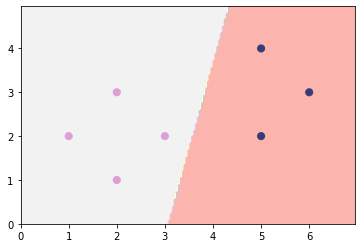

In [22]:
from numpy import shape

seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

[wReturn, wH] = lr_train(seven_X, seven_y, trace=True)
print(wReturn)
print("Cross entropy err: ", cross_entropy_error(seven_X, seven_y, wReturn))

def f(x):
    return lr_h(x, wReturn) >= 0.5

plot_2d_clf_problem(seven_X, seven_y, f)

**Q:** Koji kriterij zaustavljanja je aktiviran?

**Q:** Zašto dobivena pogreška unakrsne entropije nije jednaka nuli?

**Q:** Kako biste utvrdili da je optimizacijski postupak doista pronašao hipotezu koja minimizira pogrešku učenja? O čemu to ovisi?

**Q:** Na koji način biste preinačili kôd ako biste htjeli da se optimizacija izvodi stohastičkim gradijentnim spustom (*online learning*)?

### (d)

Prikažite na jednom grafikonu pogrešku unakrsne entropije (očekivanje logističkog gubitka) i pogrešku klasifikacije (očekivanje gubitka 0-1) na skupu `seven` kroz iteracije optimizacijskog postupka. Koristite trag težina funkcije `lr_train` iz zadatka (b) (opcija `trace=True`). Na drugom grafikonu prikažite pogrešku unakrsne entropije kao funkciju broja iteracija za različite stope učenja, $\eta\in\{0.005,0.01,0.05,0.1\}$.

In [23]:
from sklearn.metrics import zero_one_loss

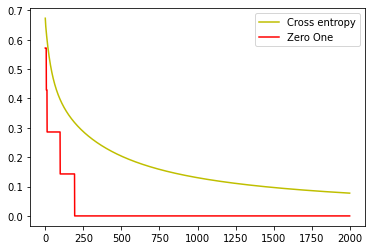

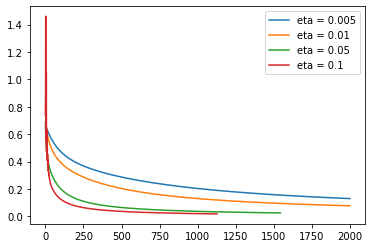

In [24]:

etaList = [0.005, 0.01, 0.05, 0.1]
w, wHist = lr_train(seven_X, seven_y, trace=True)

phi = PolynomialFeatures(1).fit_transform(seven_X)

def g(x):
    return x >= 0.5

errorEnt = []
errorZeroOne = []
err = []

for i in range(len(wHist)):
    errorEnt.append(cross_entropy_error(seven_X, seven_y, wHist[i]))
    eList = []
    for p in phi:
        eList.append(g(sigmoid(p @ wHist[i])))
    errorZeroOne.append(zero_one_loss(seven_y, eList))

for eta in etaList:
    er = []
    w, wHist = lr_train(seven_X, seven_y, eta, trace=True)
    for i in range(len(wHist)):
        er.append(cross_entropy_error(seven_X,seven_y, wHist[i]))
    err.append(er)

plt.plot(errorEnt, "y", label = "Cross entropy")
plt.plot(errorZeroOne, "r", label = "Zero One")
plt.legend()

plt.figure()
for i in range(len(etaList)):
    plt.plot(err[i], label="eta = " + str(etaList[i]))
plt.legend()


**Q:** Zašto je pogreška unakrsne entropije veća od pogreške klasifikacije? Je li to uvijek slučaj kod logističke regresije i zašto?

**Q:** Koju stopu učenja $\eta$ biste odabrali i zašto?

### (e)

Upoznajte se s klasom [`linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) koja implementira logističku regresiju. Usporedite rezultat modela na skupu `seven` s rezultatom koji dobivate pomoću vlastite implementacije algoritma.

**NB:** Kako ugrađena implementacija koristi naprednije verzije optimizacije funkcije, vrlo je vjerojatno da Vam se rješenja neće poklapati, ali generalne performanse modela bi trebale. Ponovno, pripazite na broj iteracija i snagu regularizacije.

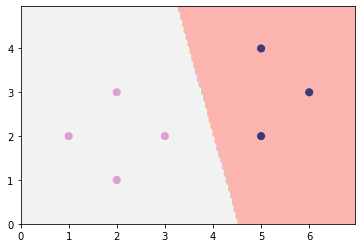

In [25]:
from sklearn.linear_model import LogisticRegression

regressionF = LogisticRegression(max_iter=2000, tol=0.0001).fit(seven_X, seven_y)

def hPred(x):
    return regressionF.predict(x)
plot_2d_clf_problem(seven_X, seven_y, hPred)

### 2. Analiza logističke regresije

### (a)

Koristeći ugrađenu implementaciju logističke regresije, provjerite kako se logistička regresija nosi s vrijednostima koje odskaču. Iskoristite skup `outlier`. Prikažite granicu između klasa.

In [26]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

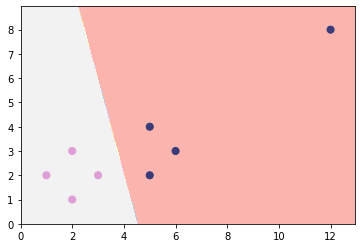

In [27]:
lr = LogisticRegression(max_iter=2000, tol=0.0001).fit(outlier_X, outlier_y)
def h(x):
    return lr.predict(x)
plot_2d_clf_problem(outlier_X, outlier_y, h)

**Q:** Zašto se rezultat razlikuje od onog koji je dobio model klasifikacije linearnom regresijom iz prvog zadatka?

### (b)

Trenirajte model logističke regresije na skupu `seven` te na dva odvojena grafikona prikažite, kroz iteracije optimizacijskoga algoritma, (1) izlaz modela $h(\mathbf{x})$ za svih sedam primjera te (2) vrijednosti težina $w_0$, $w_1$, $w_2$.

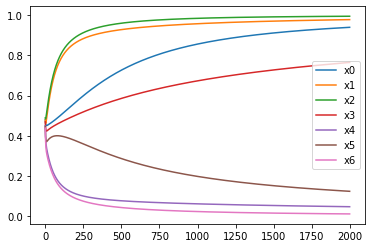

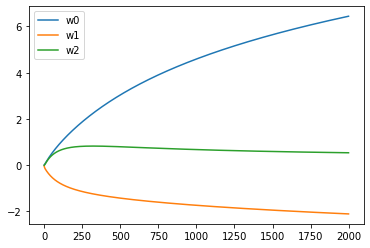

In [28]:
w, wHist = lr_train(seven_X, seven_y, trace=True)

w0=[]
w1=[]
w2=[]

hList=[]

for i in range(len(wHist)):
    w0.append(wHist[i][0])
    w1.append(wHist[i][1])
    w2.append(wHist[i][2])

for i in range(len(seven_X)):
    temp = []

    for o in range(len(wHist)):
        val = lr_h(seven_X[i], wHist[o])
        temp.append(val)
    hList.append(temp.copy())

for i in range(len(seven_X)):
    plt.plot(hList[i], label="x" + str(i))
plt.legend()

plt.figure()
plt.plot(w0, label="w0")
plt.plot(w1, label="w1")
plt.plot(w2, label="w2")
plt.legend()

### (c)

Ponovite eksperiment iz podzadatka (b) koristeći linearno neodvojiv skup podataka `unsep`.

In [29]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

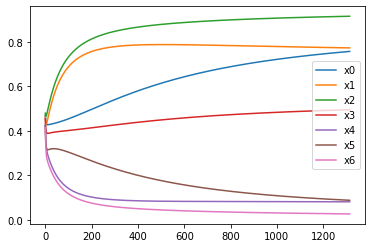

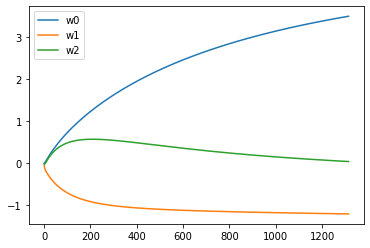

In [30]:
w, wHist = lr_train(unsep_X, unsep_y, trace=True)

w0=[]
w1=[]
w2=[]

hList=[]

for i in range(len(wHist)):
    w0.append(wHist[i][0])
    w1.append(wHist[i][1])
    w2.append(wHist[i][2])

for i in range(len(seven_X)):
    temp = []

    for o in range(len(wHist)):
        val = lr_h(seven_X[i], wHist[o])
        temp.append(val)
    hList.append(temp.copy())

for i in range(len(seven_X)):
    plt.plot(hList[i], label="x" + str(i))
plt.legend()

plt.figure()
plt.plot(w0, label="w0")
plt.plot(w1, label="w1")
plt.plot(w2, label="w2")
plt.legend()

**Q:** Usporedite grafikone za slučaj linearno odvojivih i linearno neodvojivih primjera te komentirajte razliku.

### 3. Regularizirana logistička regresija

Trenirajte model logističke regresije na skupu `seven` s različitim faktorima L2-regularizacije, $\alpha\in\{0,1,10,100\}$. Prikažite na dva odvojena grafikona (1) pogrešku unakrsne entropije te (2) L2-normu vektora $\mathbf{w}$ kroz iteracije optimizacijskog algoritma.

In [31]:
from numpy.linalg import norm

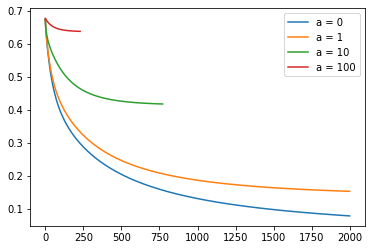

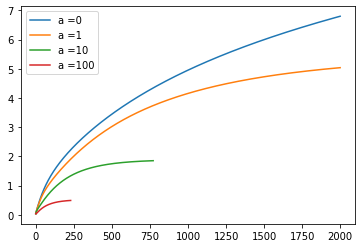

In [32]:
alphas = [0,1,10,100]

err = []
norm = []

for alpha in alphas:
    e = []
    n = []
    w, wHist = lr_train(seven_X, seven_y, max_iter=2000, alpha=alpha, trace=True)

    for i in range(len(wHist)):
        n.append(linalg.norm(wHist[i]))
        e.append(cross_entropy_error(seven_X, seven_y, wHist[i]))
    err.append(e.copy())
    norm.append(n.copy())

for i in range(len(err)):
    plt.plot(err[i], label = "a = " + str(alphas[i]))
plt.legend()
plt.figure()

for i in range(len(norm)):
    plt.plot(norm[i], label="a =" + str(alphas[i]))
plt.legend()

**Q:** Jesu li izgledi krivulja očekivani i zašto?

**Q:** Koju biste vrijednost za $\alpha$ odabrali i zašto?

### 4. Logistička regresija s funkcijom preslikavanja

Proučite funkciju [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Generirajte i prikažite dvoklasan skup podataka s ukupno $N=100$ dvodimenzijskih ($n=2)$ primjera, i to sa dvije grupe po klasi (`n_clusters_per_class=2`). Malo je izgledno da će tako generiran skup biti linearno odvojiv, međutim to nije problem jer primjere možemo preslikati u višedimenzijski prostor značajki pomoću klase [`preprocessing.PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), kao što smo to učinili kod linearne regresije u prvoj laboratorijskoj vježbi. Trenirajte model logističke regresije koristeći za preslikavanje u prostor značajki polinomijalnu funkciju stupnja $d=2$ i stupnja $d=3$. Prikažite dobivene granice između klasa. Možete koristiti svoju implementaciju, ali se radi brzine preporuča koristiti `linear_model.LogisticRegression`. Regularizacijski faktor odaberite po želji.

**NB:** Kao i ranije, za prikaz granice između klasa koristite funkciju `plot_2d_clf_problem`. Funkciji kao argumente predajte izvorni skup podataka, a preslikavanje u prostor značajki napravite unutar poziva funkcije `h` koja čini predikciju, na sljedeći način:

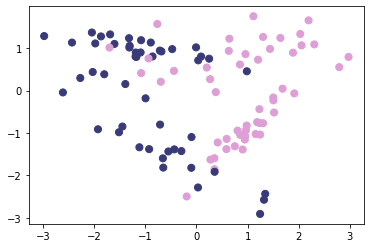

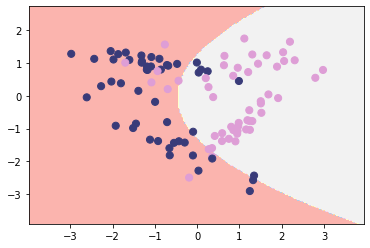

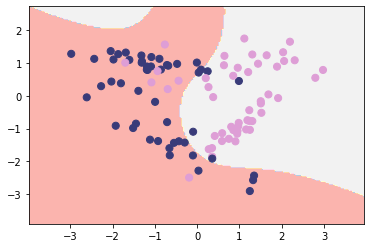

In [33]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=100, n_features=2, n_clusters_per_class=2, n_classes=2, n_redundant=0)
plot_2d_clf_problem(X, y)

degrees = [2, 3]



for d in degrees:
    plt.figure()
    poly = PolynomialFeatures(d)
    phi = poly.fit_transform(X)

    model = LogisticRegression()
    fitted = model.fit(phi, y)

    plot_2d_clf_problem(X, y, lambda x : model.predict(poly.transform(x)))

In [34]:


# Vaš kôd ovdje

**Q:** Koji biste stupanj polinoma upotrijebili i zašto? Je li taj odabir povezan s odabirom regularizacijskog faktora $\alpha$? Zašto?